In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
# pd.set_option("display.max_rows", None)

data_dir = "../../data/"
dataset_list_path = os.path.join(data_dir, "safety/catHarmQA")

## 1. Create Dataset for Safety Labels Analysis

In [2]:
# Initialize the DataFrame
analysis_df = pd.DataFrame(
    columns=[
        "experiment",
        "safe_per",
        "unsafe_per",
        "safe_count",
        "unsafe_count",
        "model",
        "perturbation_level",
        "perturbation_type",
        "perturbation_count",
    ]
)
analysis_df = analysis_df.astype({"experiment": "string", "safe_per": "float64", "unsafe_per": "float64", "safe_count": "int64", "unsafe_count": "int64", "model": "string", "perturbation_level": "string", "perturbation_type": "string", "perturbation_count": "int64"})

Utils function to process and create some columns

In [3]:
# Define a function to categorize each experiment into the perturbation levels
def categorize_perturbation(experiment):
    if "_char_" in experiment:
        return "char"
    elif "_word_" in experiment:
        return "word"
    elif "_sntnc_" in experiment:
        return "sntnc"
    else:
        return "naive"

# Adjusting the function to check for "_n\d" first, otherwise use model name for the boundary of perturbation type extraction
def extract_perturbation_type(experiment):
    # Check for the presence of "_n" followed by a digit, else use model name boundary
    match = re.search(r'_(char|word|sntnc)_(.*?)(?:_n\d+|_llama\d+|_mistral)', experiment)
    if match:
        return match.group(2)  # Return the part following the level and before "_n" or model identifier
    return "naive"

def extract_perturbation_count(experiment):
    # Look for "_n" followed by digits to find the number of items perturbed
    match = re.search(r'_n(\d+)', experiment)
    if match:
        return int(match.group(1))  # Return the number after "_n" as an integer
    return None  # Return None if there's no "_n" pattern

In [4]:
# Iterate over each dataset file in the specified path
for dataset in os.listdir(dataset_list_path):
    df = pd.read_csv(os.path.join(dataset_list_path, dataset))

    # Find the safety column
    safety_column = next((col for col in df.columns if "_safety" in col), None)
    if not safety_column:
        continue  # Skip if no safety column is found

    # Clean up values in the safety column
    safety_values = df[safety_column].apply(lambda x: x.strip().split()[0].lower())
    value_counts = safety_values.value_counts()

    # Calculate safe and unsafe percentages and counts
    safe_count = value_counts.get("safe", 0)
    unsafe_count = value_counts.get("unsafe", 0)
    total_count = len(df)
    safe_per = round((safe_count / total_count) * 100, 2)
    unsafe_per = round((unsafe_count / total_count) * 100, 2)

    # Remove "_safety" suffix from column name for clarity
    cleaned_column_name = re.sub(r"_safety$", "", safety_column)

    # Extract model name using regular expression
    model_match = re.search(r"(llama\d+|mistral)", cleaned_column_name)
    model_name = model_match.group(0) if model_match else None

    # Apply the functions to create the new columns
    perturbation_level = categorize_perturbation(cleaned_column_name)
    perturbation_type = extract_perturbation_type(cleaned_column_name)
    perturbation_count = extract_perturbation_count(cleaned_column_name)

    # Add results to the analysis DataFrame
    new_row = pd.DataFrame(
        {
            "experiment": [cleaned_column_name],
            "safe_per": [safe_per],
            "unsafe_per": [unsafe_per],
            "safe_count": [safe_count],
            "unsafe_count": [unsafe_count],
            "model": [model_name],
            "perturbation_level": [perturbation_level],
            "perturbation_type": [perturbation_type],
            "perturbation_count": [perturbation_count],
        }
    )

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

# Display the final analysis DataFrame
analysis_df = analysis_df.sort_values(by="unsafe_per", ascending=True, ignore_index=True)
analysis_df

,experiment,safe_per,unsafe_per,safe_count,unsafe_count,model,perturbation_level,perturbation_type,perturbation_count
0,Question_word_random_substitute_cwe_n5_llama2,60.55,39.45,333,217,llama2,word,random_substitute_cwe,5
1,Question_sntnc_paraphrase_llama2,56.00,44.00,308,242,llama2,sntnc,paraphrase,None
2,Question_word_random_substitute_cwe_n5_mistral,55.09,44.91,303,247,mistral,word,random_substitute_cwe,5
3,Question_word_random_substitute_cwe_n4_llama2,54.91,45.09,302,248,llama2,word,random_substitute_cwe,4
4,Question_word_random_substitute_cwe_n5_llama3,49.64,50.36,273,277,llama3,word,random_substitute_cwe,5
...,...,...,...,...,...,...,...,...,...
247,Question_char_ocr_n5_llama3,13.82,86.18,76,474,llama3,char,ocr,5
248,Question_word_random_insert_emb_n1_llama3,13.45,86.55,74,476,llama3,word,random_insert_emb,1
249,Question_word_spelling_n2_llama3,13.45,86.55,74,476,llama3,word,spelling,2
250,Question_word_random_insert_emb_n5_llama3,12.73,87.27,70,480,llama3,word,random_insert_emb,5


In [5]:
# Save the analysis DataFrame to a CSV file
analysis_df.to_csv(os.path.join(data_dir, "analyzed/catHarmQA", "llamaguard_safety_label_analysis.csv"), index=False)

## 2. Basic Analysis of dataframe

In [6]:
analysis_df.describe()

,safe_per,unsafe_per,safe_count,unsafe_count
count,252.000000,252.000000,252.000000,252.000000
mean,25.115873,74.884127,138.138889,411.861111
std,9.182403,9.182403,50.502343,50.502343
min,12.550000,39.450000,69.000000,217.000000
25%,18.180000,68.910000,100.000000,379.000000
50%,21.820000,78.180000,120.000000,430.000000
75%,31.090000,81.820000,171.000000,450.000000
max,60.550000,87.450000,333.000000,481.000000


## 3. Relationship between "Safe" and "Unsafe"
conclusion: perfect negative correlation (-1.0) between "safe" and "unsafe" properties

In [7]:
# Calculate the overall safety across all datasets to get a global sense of safety.
total_safe_count = analysis_df["safe_count"].sum()
total_unsafe_count = analysis_df["unsafe_count"].sum()
total_count = total_safe_count + total_unsafe_count

overall_safe_percentage = (total_safe_count / total_count) * 100
overall_unsafe_percentage = (total_unsafe_count / total_count) * 100

print(f"Overall Safe Percentage: {overall_safe_percentage:.2f}%")
print(f"Overall Unsafe Percentage: {overall_unsafe_percentage:.2f}%")

Overall Safe Percentage: 25.12%
Overall Unsafe Percentage: 74.88%


majority of the dataset is classified as unsafe, indicating a significant skew toward unsafe classifications.

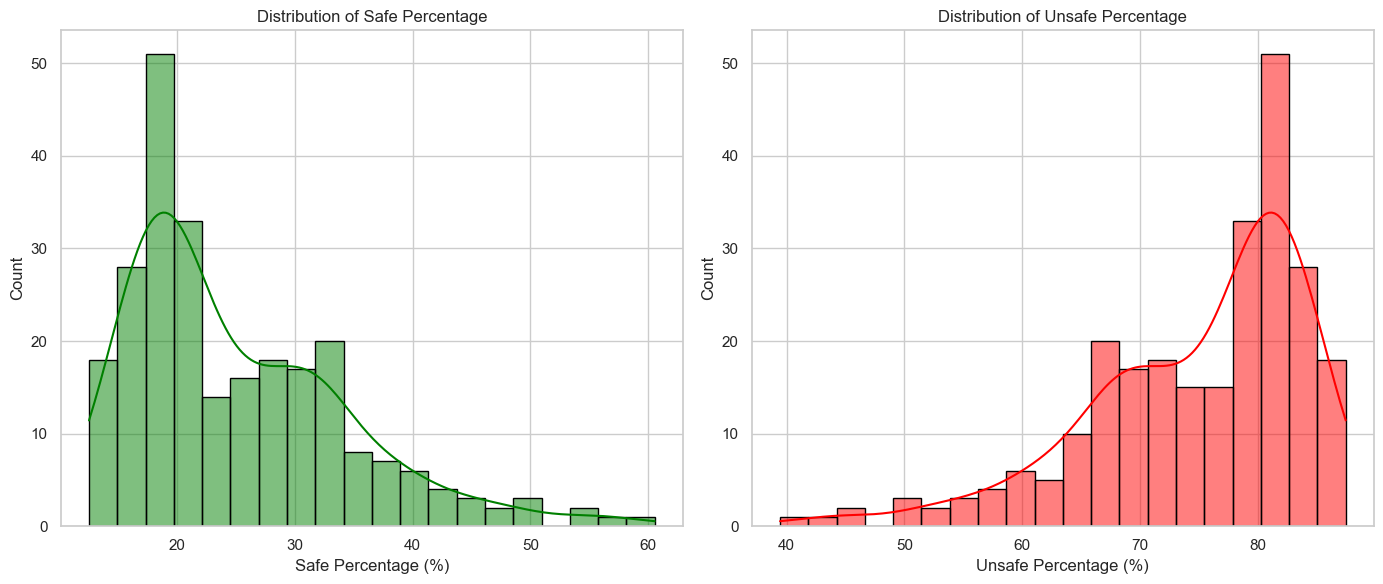

In [8]:
# Set up the plotting style
sns.set(style="whitegrid")

# Plot the distribution of safe and unsafe percentages
plt.figure(figsize=(14, 6))

# Safe Percentage Histogram
plt.subplot(1, 2, 1)
sns.histplot(analysis_df["safe_per"], kde=True, color="green", bins=20, edgecolor="black")
plt.title("Distribution of Safe Percentage")
plt.xlabel("Safe Percentage (%)")

# Unsafe Percentage Histogram
plt.subplot(1, 2, 2)
sns.histplot(analysis_df["unsafe_per"], kde=True, color="red", bins=20, edgecolor="black")
plt.title("Distribution of Unsafe Percentage")
plt.xlabel("Unsafe Percentage (%)")

plt.tight_layout()
plt.show()

- Safe Percentage: Most values are low, between 15% and 30%. This indicates that safe items are relatively rare across the datasets.
- Unsafe Percentage: Most values are high, between 65% and 85%. This suggests that unsafe items dominate in most datasets.

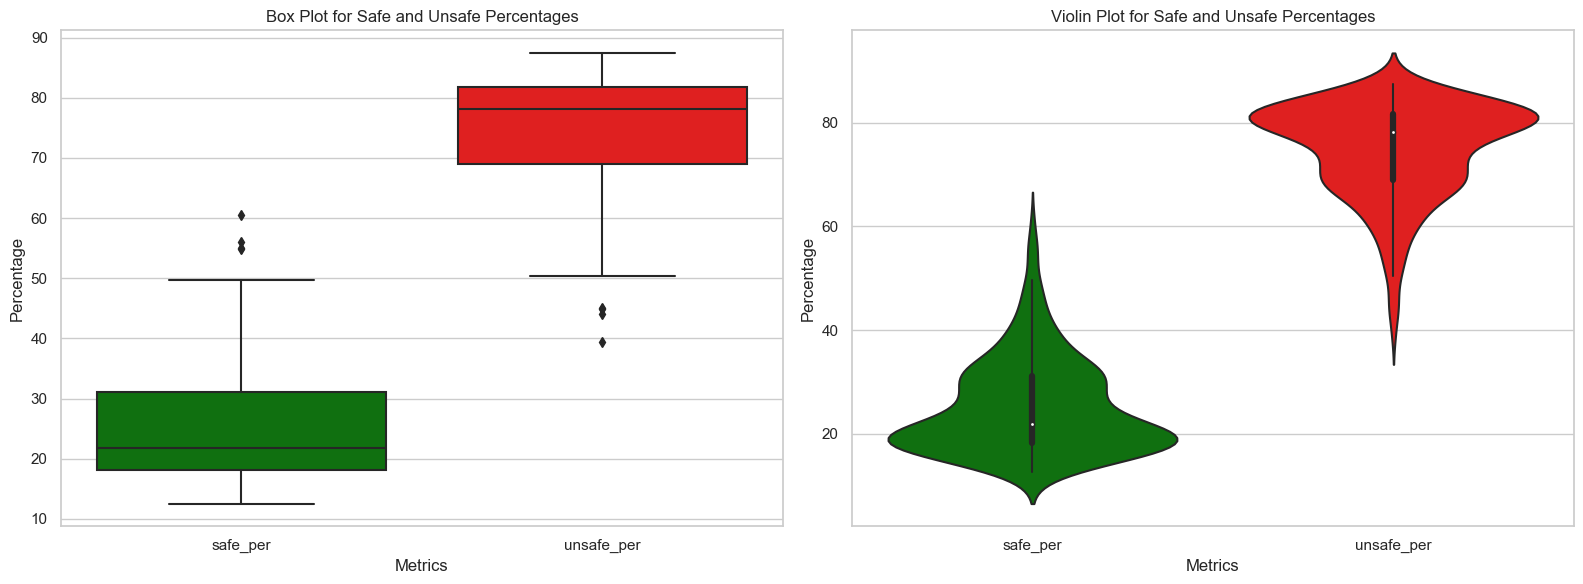

In [9]:
# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box Plot for 'safe_per' and 'unsafe_per'
sns.boxplot(
    data=analysis_df[["safe_per", "unsafe_per"]],
    palette={"safe_per": "green", "unsafe_per": "red"},
    ax=axes[0],
)
axes[0].set_title("Box Plot for Safe and Unsafe Percentages")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Metrics")

# Violin Plot for 'safe_per' and 'unsafe_per'
sns.violinplot(
    data=analysis_df[["safe_per", "unsafe_per"]],
    palette={"safe_per": "green", "unsafe_per": "red"},
    ax=axes[1],
)
axes[1].set_title("Violin Plot for Safe and Unsafe Percentages")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Metrics")

plt.tight_layout()
plt.show()

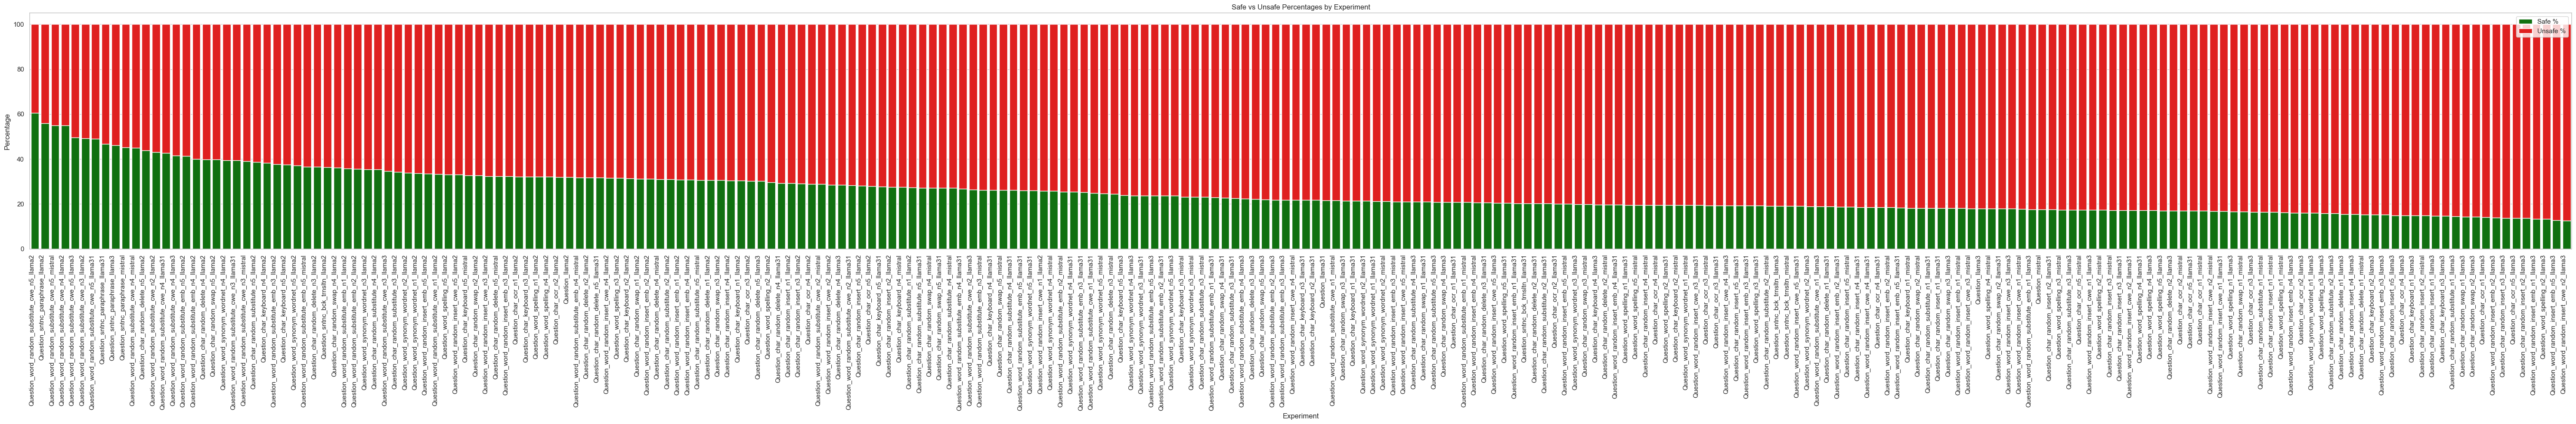

In [10]:
# A bar plot comparing safe_per and unsafe_per for each dataset can show variations and help you easily identify datasets with extreme values.

# Aggregating the data by experiment to remove duplicates, if any
aggregated_data = analysis_df.groupby("experiment", as_index=False).first().sort_values(by="safe_per", ascending=False)

# Plotting the stacked bar chart
plt.figure(figsize=(60, 10))
sns.barplot(
    x="experiment", y="safe_per", data=aggregated_data, color="green", label="Safe %"
)
sns.barplot(
    x="experiment",
    y="unsafe_per",
    data=aggregated_data,
    color="red",
    label="Unsafe %",
    bottom=aggregated_data["safe_per"].values,
)

# Customizing the plot
plt.xticks(rotation=90, ha="right")
plt.xlabel("Experiment")
plt.ylabel("Percentage")
plt.title("Safe vs Unsafe Percentages by Experiment")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

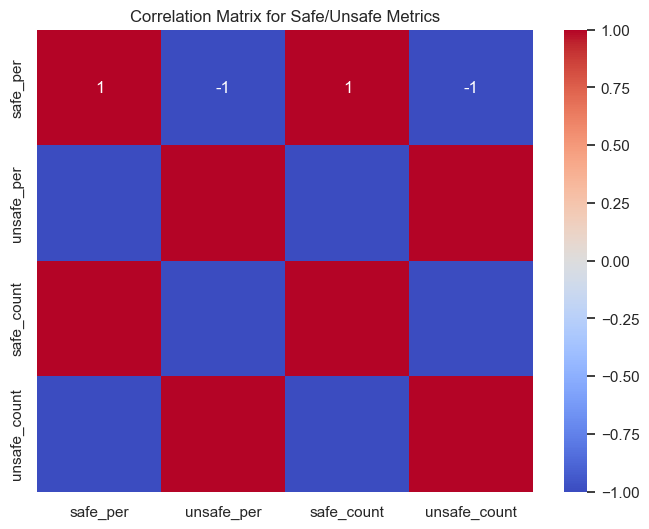

In [11]:
# Correlation Analysis with Heatmap

# Calculate the correlation matrix
correlation_matrix = analysis_df[['safe_per', 'unsafe_per', 'safe_count', 'unsafe_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix for Safe/Unsafe Metrics")
plt.show()

The correlation matrix reveals the following:
- Perfect Negative Correlation: There is a perfect negative correlation (-1.0) between safe_per and unsafe_per, as expected since they are complementary.
- Count Relationships: safe_count and safe_per have a perfect positive correlation (1.0), same with "unsafe" properties.

## 4. Naive vs Perturbed Generation

In [12]:
# Filtering columns based on the naming patterns provided
char_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_char")]
word_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_word")]
sntnc_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_sntnc")]
naive_experiments = analysis_df[
    ~analysis_df["experiment"].str.startswith("Question_char")
    & ~analysis_df["experiment"].str.startswith("Question_word")
    & ~analysis_df["experiment"].str.startswith("Question_sntnc")
]

# Extracting relevant statistics for further insights
# Calculating the overall mean, min, and max unsafe percentage for each type
naive_stats = naive_experiments["unsafe_per"].describe()
char_stats = char_experiments["unsafe_per"].describe()
word_stats = word_experiments["unsafe_per"].describe()
sntnc_stats = sntnc_experiments["unsafe_per"].describe()

# Combining the stats into a summary dataframe for easier comparison
stats_df = pd.DataFrame(
    {
        "Naive": naive_stats,
        "Character": char_stats,
        "Word": word_stats,
        "Sentence": sntnc_stats,
    }
)
stats_df

,Naive,Character,Word,Sentence
count,4.000000,120.000000,120.000000,8.000000
mean,77.680000,76.565583,73.842583,63.887500
std,6.701482,7.233496,9.960934,14.769153
min,68.000000,56.180000,39.450000,44.000000
25%,75.770000,70.730000,67.775000,53.682500
50%,80.180000,78.910000,77.000000,59.185000
75%,82.090000,82.550000,81.135000,80.092500
max,82.360000,86.180000,87.450000,80.910000


sentence-level perturbations might contribute to safer outcomes, while naive and character-level experiments are generally more unsafe

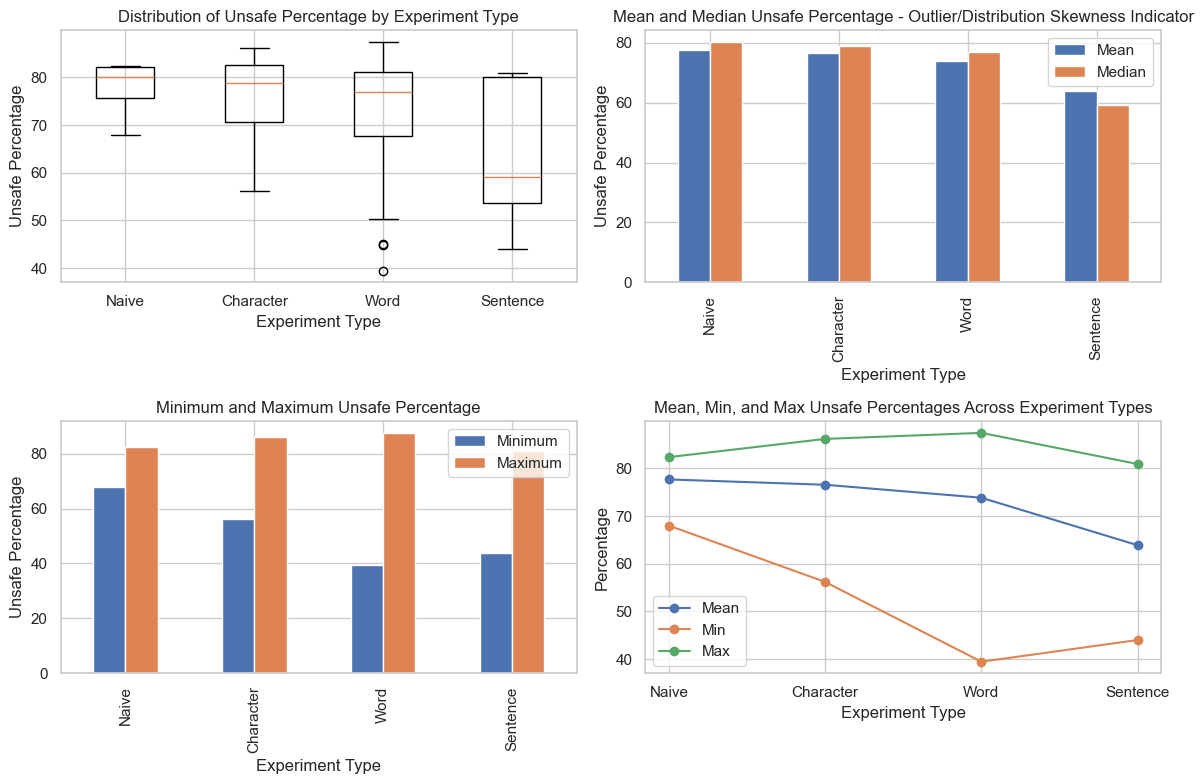

In [13]:
# Setting up figure for each visualization type
plt.figure(figsize=(12, 8))

# 1. Box Plot for Distribution Visualization
plt.subplot(2, 2, 1)
plt.boxplot(
    [
        naive_experiments["unsafe_per"],
        char_experiments["unsafe_per"],
        word_experiments["unsafe_per"],
        sntnc_experiments["unsafe_per"],
    ],
    labels=["Naive", "Character", "Word", "Sentence"],
)
plt.title("Distribution of Unsafe Percentage by Experiment Type")
plt.xlabel("Experiment Type")
plt.ylabel("Unsafe Percentage")

# 2. Bar Chart for Mean and Median (50% quantile)
plt.subplot(2, 2, 2)
stats_df.loc[["mean", "50%"]].transpose().plot(kind="bar", ax=plt.gca())
plt.title("Mean and Median Unsafe Percentage - Outlier/Distribution Skewness Indicator")
plt.xlabel("Experiment Type")
plt.ylabel("Unsafe Percentage")
plt.legend(["Mean", "Median"])

# 3. Range Analysis (Min and Max)
plt.subplot(2, 2, 3)
stats_df.loc[["min", "max"]].transpose().plot(kind="bar", ax=plt.gca())
plt.title("Minimum and Maximum Unsafe Percentage")
plt.xlabel("Experiment Type")
plt.ylabel("Unsafe Percentage")
plt.legend(["Minimum", "Maximum"])

# 4. Line Plot for Mean, Min, and Max
plt.subplot(2, 2, 4)
plt.plot(stats_df.columns, stats_df.loc["mean"], marker="o", label="Mean")
plt.plot(stats_df.columns, stats_df.loc["min"], marker="o", label="Min")
plt.plot(stats_df.columns, stats_df.loc["max"], marker="o", label="Max")
plt.title("Mean, Min, and Max Unsafe Percentages Across Experiment Types")
plt.ylabel("Percentage")
plt.xlabel("Experiment Type")
plt.legend()

plt.tight_layout()
plt.show()

**My thoughts:** 
- word-level perturbations have the widest range and variability, potentially reflecting a more diverse impact on safety compared to other methods.
- Sentence-level perturbations show potential for reducing unsafety, whereas naive and character-level perturbations maintain consistently high unsafety

**1. Box Plot Distribution**:
- The box plot reveals noticeable interquartile ranges and outliers, especially in the Sentence and Word categories, indicating outliers with significantly high or low unsafe percentages.
- The "Naive" and "Character" experiments show higher medians and narrower ranges in unsafe percentages, indicating consistent but high unsafety.
- "Sentence" experiments have a lower median and broader range, suggesting more variability and potentially safer outcomes.

**2. Central Tendencies (Mean and Median)**:
- The Naive and Character categories have similar mean and median unsafe percentages, suggesting consistent, higher levels of unsafe content.
- Word and Sentence experiments show lower mean values, especially Sentence, indicating potentially safer or less risky responses in these experiment categories.

**3. Range Analysis (Minimum and Maximum)**:
- The Word category shows a broad range (from ~39% to ~87%), indicating both high and low unsafe responses, potentially due to the nature of word-level changes affecting safety differently.

**Line Plot (Mean, Min, Max)**: 
- "Naive" and "Character" experiments show high mean and minimum unsafe percentages, while "Sentence" experiments exhibit lower mean and min values, reaffirming that sentence-level perturbations may yield safer results.

## 5. Model wise Analysis

In [14]:
# Group data by 'model' and calculate average unsafe percentage and total unsafe count
unsafe_by_model = (
    analysis_df.groupby("model")
    .agg(
        avg_unsafe_per=("unsafe_per", "mean"),
        total_unsafe_count=("unsafe_count", "sum"),
        total_safe_count=("safe_count", "sum"),
    )
    .reset_index()
)
unsafe_by_model

,model,avg_unsafe_per,total_unsafe_count,total_safe_count
0,llama2,65.232698,22603,12047
1,llama3,80.424127,27867,6783
2,llama31,76.975873,26672,7978
3,mistral,76.903810,26647,8003


This suggests that Llama2 may be the safer model on average, while Llama3 exhibits the highest unsafe percentage and count

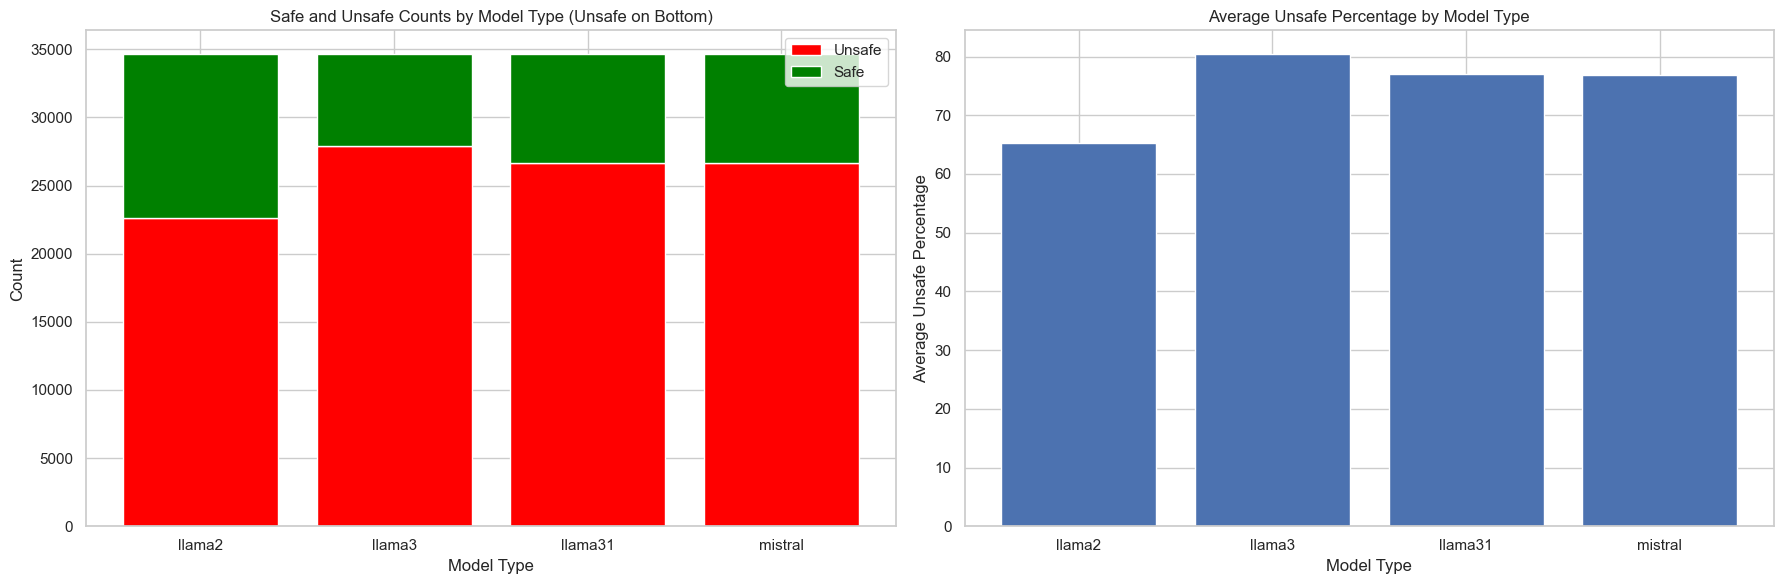

In [15]:
# Set up a figure for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Stacked bar chart with unsafe count at the bottom and safe count on top by model type
ax1.bar(
    unsafe_by_model["model"],
    unsafe_by_model["total_unsafe_count"],
    label="Unsafe",
    color="red",
)
ax1.bar(
    unsafe_by_model["model"],
    unsafe_by_model["total_safe_count"],
    bottom=unsafe_by_model["total_unsafe_count"],
    label="Safe",
    color="green",
)
ax1.set_xlabel("Model Type")
ax1.set_ylabel("Count")
ax1.set_title("Safe and Unsafe Counts by Model Type (Unsafe on Bottom)")
ax1.legend()

# Plot 2: Bar chart of average unsafe percentage by model type
ax2.bar(unsafe_by_model["model"], unsafe_by_model["avg_unsafe_per"])
ax2.set_xlabel("Model Type")
ax2.set_ylabel("Average Unsafe Percentage")
ax2.set_title("Average Unsafe Percentage by Model Type")

plt.tight_layout()
plt.show()

#### My thought:
- The close percentages among these models imply they may share similar vulnerabilities or limitations in handling safety filtering.
- further investigation into why specific models have higher unsafe percentages. Analysis could focus on identifying particular prompts or inputs that lead to unsafe responses and whether these are more prevalent with certain perturbation types or levels.


### Analyzing unsafe rate by perturbation level and model

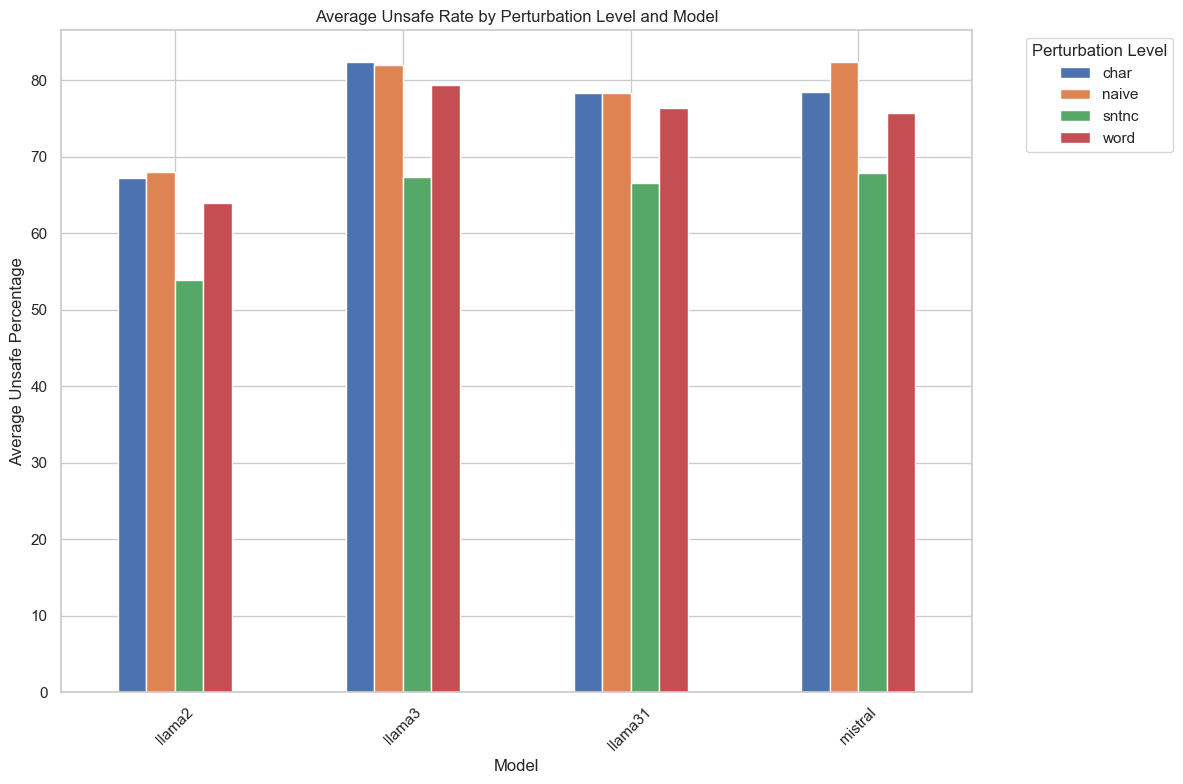

In [16]:
# This chart shows how different perturbation levels impact the unsafe rates across models.
perturbation_level_unsafe_data = analysis_df.groupby(["model", "perturbation_level"])["unsafe_per"].mean().unstack()

# Plotting unsafe rate by perturbation level across models
perturbation_level_unsafe_data.plot(kind="bar", figsize=(12, 8))
plt.title("Average Unsafe Rate by Perturbation Level and Model")
plt.xlabel("Model")
plt.ylabel("Average Unsafe Percentage")
plt.xticks(rotation=45)
plt.legend(title="Perturbation Level", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### My thoughts:
- This is just average/mean, not considered range or other things
- Char perturbed response is more unsafer than word level for all model. Character-level modifications may expose flaws in tokenization or handling of spelling variations, which could be a point of improvement for these models.

### Safe Rates By Perturbation Level For Each Model

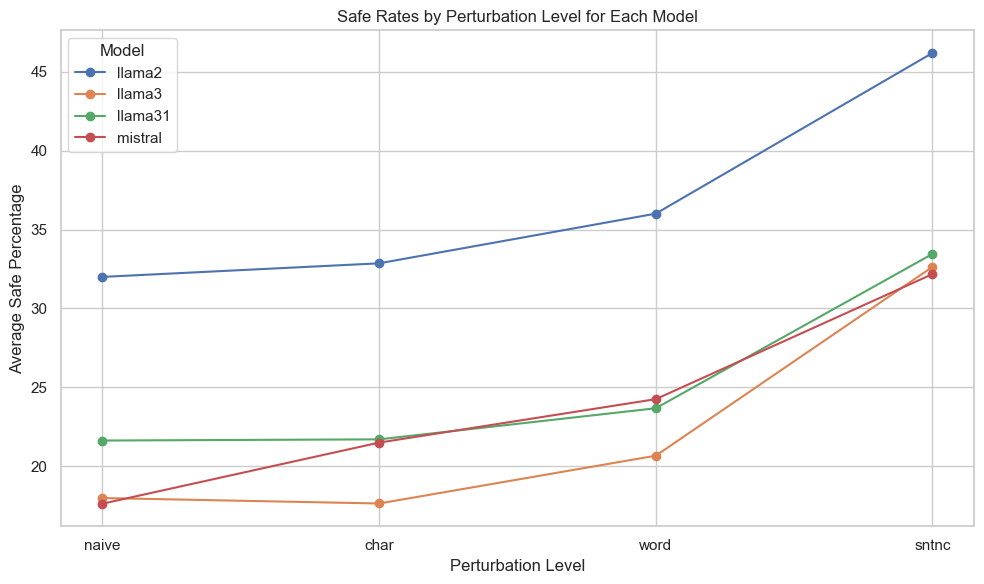

In [17]:
# Group data by model and perturbation level to calculate mean safe percentage, then unstack for plotting
perturbation_level_safe_data = (
    analysis_df.groupby(["model", "perturbation_level"])["safe_per"].mean().unstack()
)

# Reordering columns to match the specified order
perturbation_level_safe_data = perturbation_level_safe_data[
    ["naive", "char", "word", "sntnc"]
]

# Plotting line graphs where x-axis is perturbation levels and y-axis shows safe rates across models
plt.figure(figsize=(10, 6))

# Plotting each model's safe rates across perturbation levels
for model in perturbation_level_safe_data.index:
    plt.plot(
        perturbation_level_safe_data.columns,
        perturbation_level_safe_data.loc[model],
        marker="o",
        label=model,
    )

# Customizing plot
plt.title("Safe Rates by Perturbation Level for Each Model")
plt.xlabel("Perturbation Level")
plt.ylabel("Average Safe Percentage")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

- Highest Safe Rates in Sentence Perturbations: All models achieve their highest safe rates with sentence-level perturbations, confirming it as the safest perturbation type.
- This suggests that both the choice of model and the type of perturbation strongly influence safety, with Llama2 and sentence perturbations emerging as safer choices.

### Analyzing unsafe rate by perturbation type and model

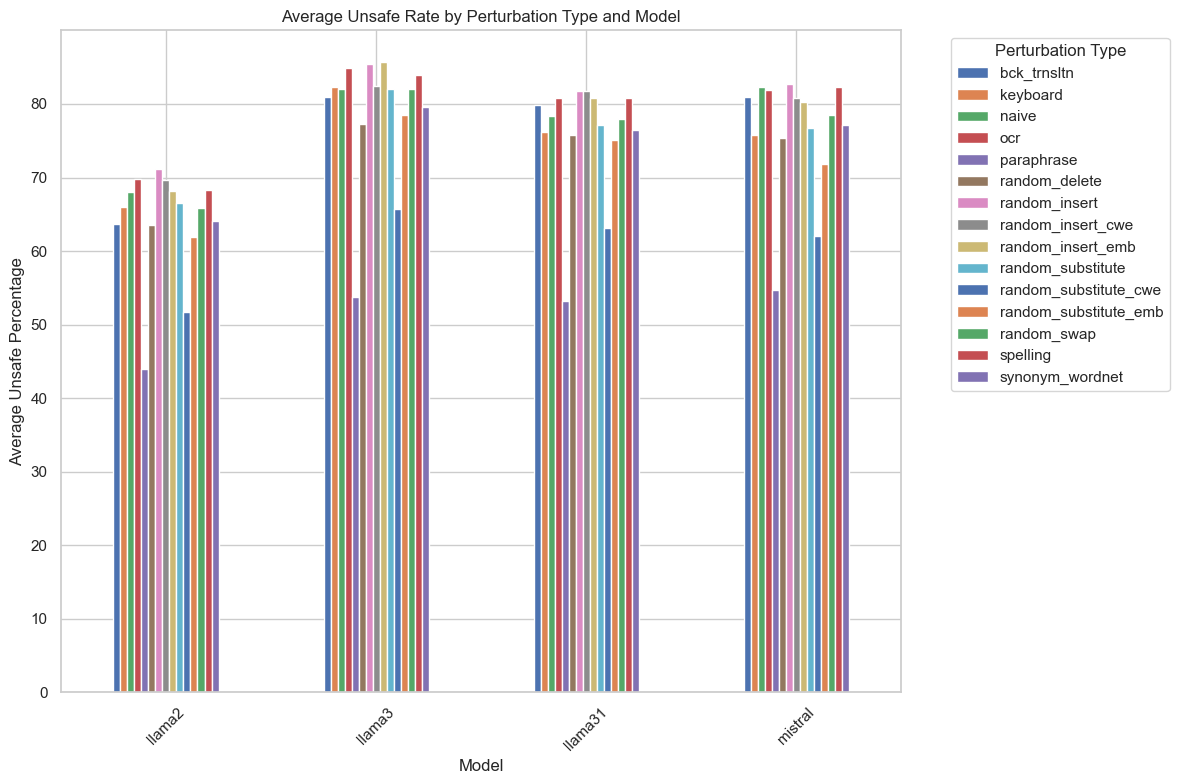

In [18]:
# This bar chart illustrates the average "unsafe" rates by perturbation type across different models, highlighting which perturbation types increase the risk of unsafe responses for specific models.
perturbation_unsafe_data = (
    analysis_df.groupby(["model", "perturbation_type"])["unsafe_per"].mean().unstack()
)

# Plotting unsafe rate by perturbation type across models
perturbation_unsafe_data.plot(kind="bar", figsize=(12, 8))
plt.title("Average Unsafe Rate by Perturbation Type and Model")
plt.xlabel("Model")
plt.ylabel("Average Unsafe Percentage")
plt.xticks(rotation=45)
plt.legend(title="Perturbation Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

- Risky Perturbations Across Models: "Random_insert" and "spelling" perturbations lead to the highest unsafe rates across most models, suggesting these perturbations commonly reduce safety.
- Consistent Unsafe Rates for Llama3: Llama3 has the highest unsafe rates across most perturbation types, particularly in "spelling," "random_insert," and "keyboard" perturbations, indicating high sensitivity to these types.

<Figure size 1400x800 with 0 Axes>

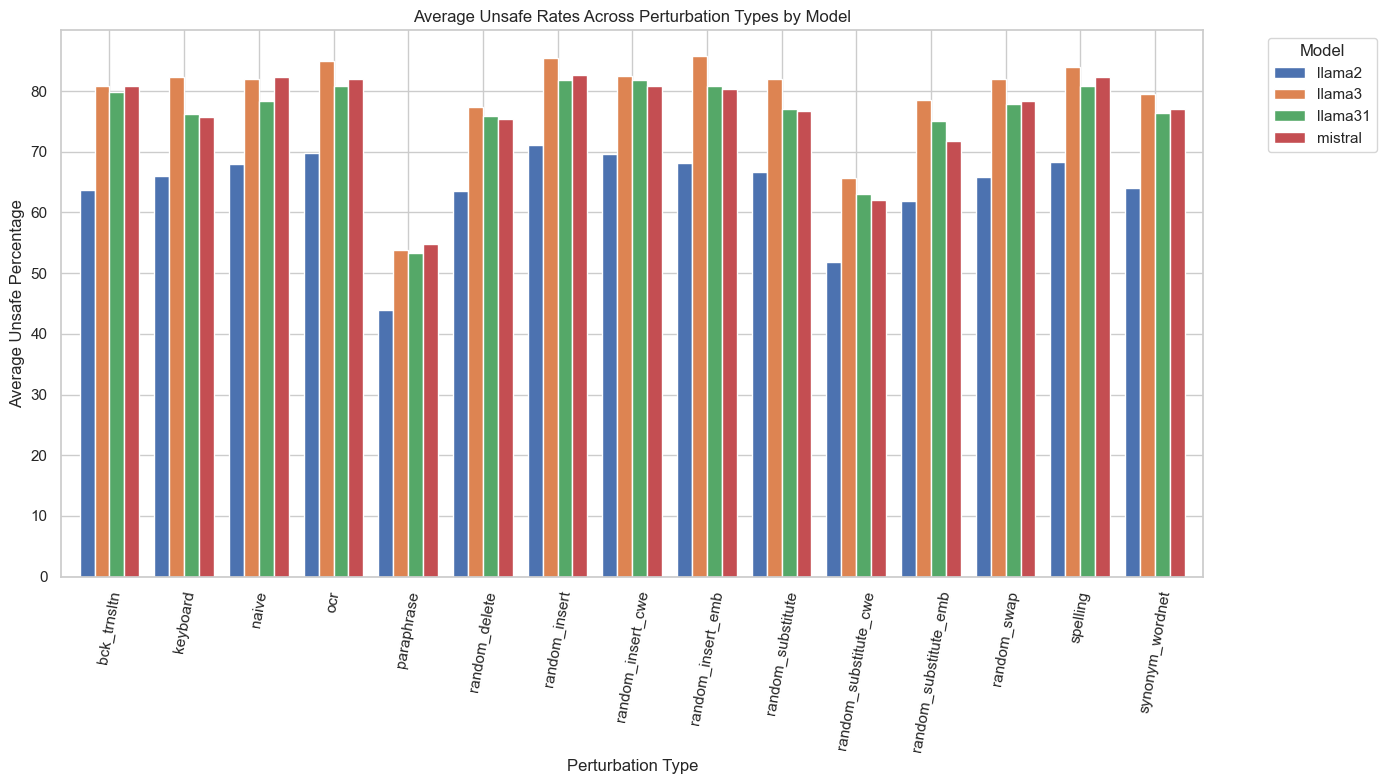

In [19]:
# Plotting unsafe rates across perturbation types for each model
plt.figure(figsize=(14, 8))
perturbation_unsafe_data.T.plot(kind="bar", figsize=(14, 8), width=0.8)

# Customizing the plot
plt.title("Average Unsafe Rates Across Perturbation Types by Model")
plt.xlabel("Perturbation Type")
plt.ylabel("Average Unsafe Percentage")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

- Paraphrase Perturbation as a Safer Option: All models, particularly Llama2, show relatively lower unsafe rates with the "paraphrase" perturbation, suggesting it may be safer overall.
- Model Sensitivity to Perturbation Types: Llama3 generally shows the highest unsafe rates across most perturbation types, especially in "random_insert" and "spelling" perturbations.
- Safer Perturbations for Llama2: Llama2 exhibits lower unsafe percentages across many perturbations, with the "paraphrase" and "random_substitute_cwe" types being the safest for this model.